# Transcriptomics visualizations
Now that we've used R to get the differentially expressed genes, we can do some visualizations of what those look like for different comparisons.

In [73]:
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Read in the data

In [74]:
datapath = '../data/deseq2_output/'
comparisons = {}
for f in listdir(datapath):
    name = '_'.join(f.split('_')[:4])
    comparisons[name] = pd.read_csv(datapath+f)

## Basic visualizations
First, let's take a look at the distributions of the log fold change for the various comparisons.

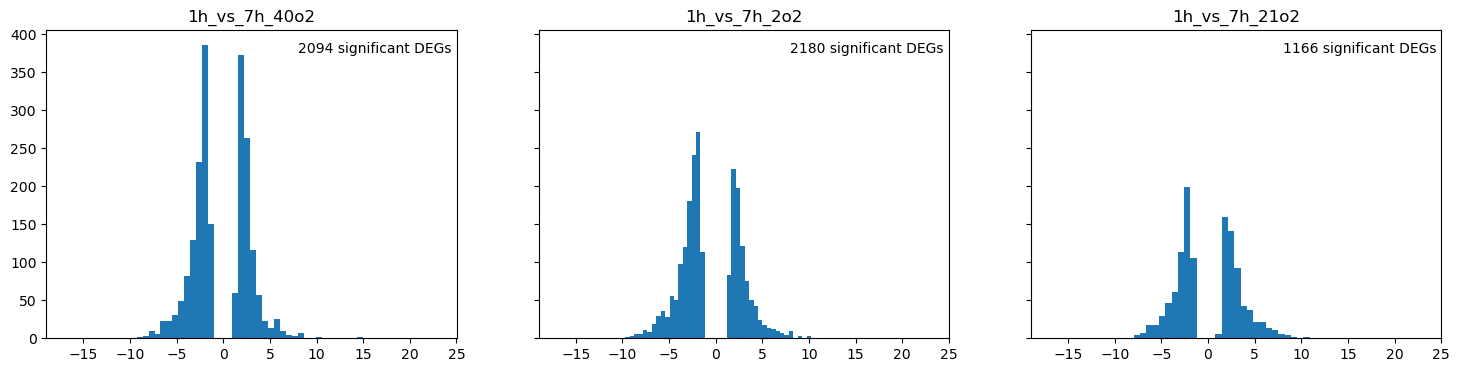

In [75]:
fig, axs = plt.subplots(1, len(comparisons), sharex=True, sharey=True, figsize=(len(comparisons)*6, 4))

for ax, comp in zip(axs, comparisons):
    ax.hist(comparisons[comp].log2FoldChange, bins=50)
    ax.set_title(comp)
    ax.text(8, 375, f'{len(comparisons[comp])} significant DEGs')

The presence of so many DEGs after 7 hours at ambient oxygen to me indicates that many of the DEGs we're seeing in the other conditions aren't related to the change in photorespiration as induced by the change in oxygen. What happens to these distributions if we remove the DEGs from 2% and 40% that are also found with the same directional change in 21%?

In [76]:
two_21_merged = pd.merge(comparisons['1h_vs_7h_2o2'], comparisons['1h_vs_7h_21o2'], left_on='gene_id', right_on='gene_id', suffixes=('_2o2', '_21o2'))
two_to_drop = two_21_merged[two_21_merged.log2FoldChange_2o2 * two_21_merged.log2FoldChange_21o2 > 0].gene_id
two_filtered_by_21 = comparisons['1h_vs_7h_2o2'][~comparisons['1h_vs_7h_2o2'].gene_id.isin(two_to_drop)].reset_index(drop=True)
two_filtered_by_21.shape

(1492, 7)

In [77]:
forty_21_merged = pd.merge(comparisons['1h_vs_7h_40o2'], comparisons['1h_vs_7h_21o2'], left_on='gene_id', right_on='gene_id', suffixes=('_40o2', '_21o2'))
forty_to_drop = forty_21_merged[forty_21_merged.log2FoldChange_40o2 * forty_21_merged.log2FoldChange_21o2 > 0].gene_id
forty_filtered_by_21 = comparisons['1h_vs_7h_40o2'][~comparisons['1h_vs_7h_40o2'].gene_id.isin(forty_to_drop)].reset_index(drop=True)
forty_filtered_by_21.shape

(1280, 7)

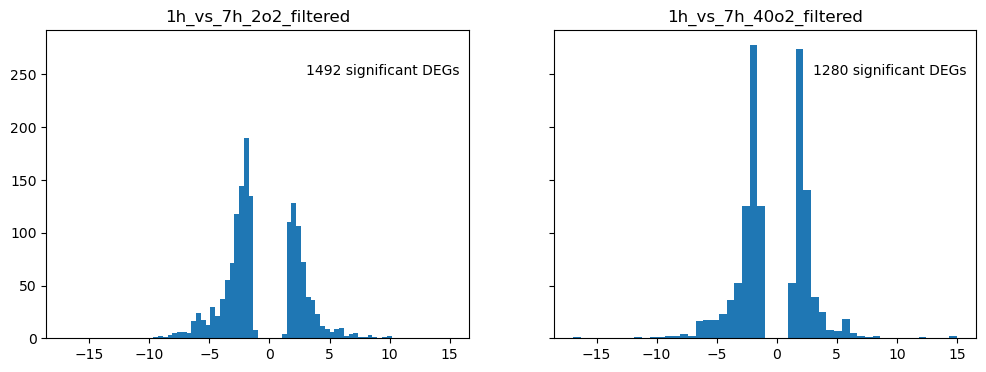

In [78]:
comps_filtered = {
    '1h_vs_7h_2o2_filtered': two_filtered_by_21,
    '1h_vs_7h_40o2_filtered': forty_filtered_by_21
}
fig, axs = plt.subplots(1, len(comps_filtered), sharex=True, sharey=True, figsize=(len(comps_filtered)*6, 4))

for ax, comp in zip(axs, comps_filtered):
    ax.hist(comps_filtered[comp].log2FoldChange, bins=50)
    ax.set_title(comp)
    ax.text(3, 250, f'{len(comps_filtered[comp])} significant DEGs')

That substantially reduces the number of genes we're interested in looking at. Now we can look at a volcano plot, which plots the log fold change against the p-value of the change:

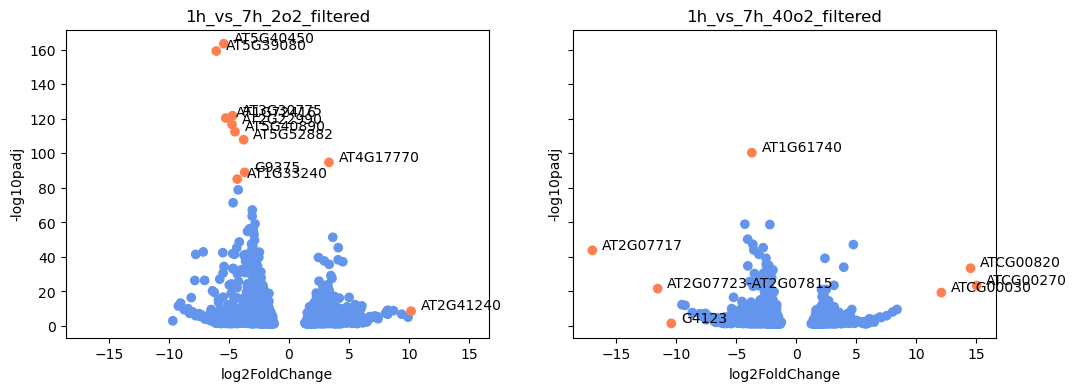

In [79]:
fig, axs = plt.subplots(1, len(comps_filtered), sharex=True, sharey=True, figsize=(len(comps_filtered)*6, 4))

for ax, comp in zip(axs, comps_filtered):
    x = comps_filtered[comp].log2FoldChange
    y = -np.log10(comps_filtered[comp].padj)
    colors = ['coral' if (abs(x_i) > 10 or y_i > 80) else 'cornflowerblue' for x_i, y_i in zip(x, y)]
    ax.scatter(x, y, c=colors)
    # Add gene name labels for the far out ones
    for i in range(len(x)):
        if colors[i] == 'coral':
            ax.annotate(comps_filtered[comp].loc[i, 'gene_id'], (x[i], y[i]), xytext=(x[i]+0.8, y[i]+0.8))

    ax.set_title(comp)
    ax.set_xlabel('log2FoldChange')
    ax.set_ylabel('-log10padj')

Generally speaking, we are interested in genes that have opposite responses at 2% vs. 40% oxygen, as the photorespiratory demands of those two conditions are opposite. Let's take a look at what genes fit that description for the hour comparisons:

In [80]:
two_forty = pd.merge(two_filtered_by_21, forty_filtered_by_21, left_on='gene_id', right_on='gene_id', suffixes=('_2o2', '_40o2'))

In [81]:
opposites_hour = two_forty[two_forty['log2FoldChange_2o2']*two_forty['log2FoldChange_40o2'] < 0]
opposites_hour.shape

(12, 13)

That gives us 12 genes, which is a very manageable number!

In [82]:
opposites_hour

,gene_id,baseMean_2o2,log2FoldChange_2o2,lfcSE_2o2,stat_2o2,pvalue_2o2,padj_2o2,baseMean_40o2,log2FoldChange_40o2,lfcSE_40o2,stat_40o2,pvalue_40o2,padj_40o2
35,AT5G01017,8.696036,-4.823019,1.149183,-4.196910,4.395640e-04,5.595106e-03,9.180972,4.329888,1.118896,3.869788,1.460892e-03,1.692656e-02
64,G16165,15.246974,-3.805237,0.956607,-3.977846,1.681559e-03,1.874650e-02,5.960827,5.762284,1.371989,4.199949,2.595981e-04,3.634198e-03
118,AT2G40610,22.539977,-2.862264,0.578805,-4.945124,6.467298e-04,7.979639e-03,111.505157,2.149067,0.270664,7.939993,1.091168e-05,2.105557e-04
140,AT5G14740,18253.848781,-2.618728,0.180860,-14.479289,1.774859e-19,1.012182e-17,24407.542818,1.490095,0.136201,10.940386,1.601426e-04,2.392318e-03
162,AT5G24490,103.323694,-2.386220,0.278086,-8.580867,3.100370e-07,6.489868e-06,347.457155,1.365425,0.127396,10.717942,2.062675e-03,2.308524e-02
185,AT1G67865,779.194706,-2.166855,0.232976,-9.300751,2.743212e-07,5.775630e-06,541.438753,1.717651,0.227433,7.552335,8.012839e-04,9.946393e-03
267,AT3G27830,3593.700942,-1.359634,0.114830,-11.840433,8.684304e-04,1.039056e-02,4165.358638,1.988061,0.175869,11.304226,9.649466e-09,3.141387e-07
275,AT4G17670,152.783773,1.550826,0.192222,8.067886,2.081288e-03,2.271332e-02,62.290521,-2.570223,0.350390,-7.335327,3.708411e-06,7.724612e-05
324,AT2G16890,288.957852,2.572726,0.251985,10.209843,2.169040e-10,6.233983e-09,59.850892,-2.822186,0.412628,-6.839537,5.026087e-06,1.017254e-04
329,AT3G29590,88.913031,2.710999,0.538251,5.036684,7.393943e-04,8.990240e-03,25.056543,-3.151068,0.783300,-4.022811,3.014919e-03,3.221047e-02
